## Setup

In [1]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import load_iris, load_breast_cancer, fetch_california_housing
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

from models.notmiwae import NotMIWAE

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
def introduce_mnar_missing(X, missing_rate=0.3, a=-10.0, b=5.0):
    """
    Introduce MNAR missing values (self-masking known):
    higher values more likely to be missing for first half of features.
    
    Parameters:
    - X: np.array of shape (n_samples, n_features)
    - missing_rate: approximate fraction of missing values
    - a: slope of sigmoid (negative -> higher values more missing)
    - b: bias of sigmoid (controls overall missing rate)
    
    Returns:
    - X_nan: X with NaNs for missing entries
    - X_filled: missing entries replaced with zeros
    - mask: 1 if observed, 0 if missing
    """
    X_nan = X.copy()
    mask = np.ones_like(X)
    n_samples, D = X.shape
    
    for j in range(D // 2):
        # compute probability of being observed for each entry
        probs_observed = sigmoid(a * X[:, j] + b)
        # sample mask: 1 = observed, 0 = missing
        sampled_mask = np.random.binomial(1, probs_observed)
        X_nan[:, j][sampled_mask == 0] = np.nan
        mask[:, j] = sampled_mask
    
    X_filled = np.nan_to_num(X_nan, nan=0.0)
    return X_nan, X_filled, mask

In [3]:
def train_notmiwae_and_impute(X_train_filled, mask_train, n_epochs=100):
    """Train not-MIWAE and return imputed data."""
    D = X_train_filled.shape[1]
    
    X_t = torch.tensor(X_train_filled, dtype=torch.float32)
    mask_t = torch.tensor(mask_train, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_t, mask_t)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    model = NotMIWAE(
        input_dim=D,
        latent_dim=max(D - 1, 2),
        hidden_dim=64,
        n_samples=10,
        out_dist='gauss',
        missing_process='selfmasking_known'
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(n_epochs):
        total_loss = 0
        for x, s in train_loader:
            x, s = x.to(device), s.to(device)
            optimizer.zero_grad()
            out = model(x, s)
            loss = out['loss']
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader):.4f}")
    
    model.eval()
    with torch.no_grad():
        X_imputed = model.impute(X_t.to(device), mask_t.to(device), n_samples=100).cpu().numpy()
    
    return X_imputed

In [4]:
def plot_original_vs_imputed(X_original, X_imputed, y, feature_names, dataset_name, task_type='regression'):
    """
    Plot original data (blue) vs imputed data (red) for each feature against target.
    
    Args:
        X_original: Original standardized data
        X_imputed: Imputed data
        y: Target variable
        feature_names: List of feature names
        dataset_name: Name of the dataset for title
        task_type: 'regression' or 'classification'
    """
    n_features = X_original.shape[1]
    n_cols = 4 if n_features > 4 else n_features
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_features > 1 else axes
    
    for i in range(n_features):
        # Plot original data in blue
        axes[i].scatter(X_original[:, i], y, alpha=0.4, s=15, c='blue', label='Original', edgecolors='none')
        # Plot imputed data in red
        axes[i].scatter(X_imputed[:, i], y, alpha=0.4, s=15, c='red', label='Imputed', edgecolors='none')
        
        axes[i].set_xlabel(feature_names[i] if i < len(feature_names) else f'Feature {i}')
        axes[i].set_ylabel('Target')
        axes[i].set_title(f'{feature_names[i] if i < len(feature_names) else f"Feature {i}"} vs Target')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(markerscale=1.5)
    
    # Hide extra subplots
    for i in range(n_features, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'{dataset_name}: Original (Blue) vs Imputed (Red)', y=1.001, fontsize=14, fontweight='bold')
    plt.show()

In [5]:
def plot_imputed_points_only(X_original, X_imputed, y, mask, feature_names, dataset_name):
    """
    Plot only the imputed data points (where mask == 0), comparing original (blue) vs imputed (red) values.
    
    Args:
        X_original: Original standardized data
        X_imputed: Imputed data
        y: Target variable
        mask: Binary mask (1 = observed, 0 = missing/imputed)
        feature_names: List of feature names
        dataset_name: Name of the dataset for title
    """
    n_features = X_original.shape[1]
    n_cols = 4 if n_features > 4 else n_features
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_features > 1 else axes
    
    for i in range(n_features):
        # Get indices where this feature was missing (imputed)
        imputed_mask = mask[:, i] == 0
        
        if imputed_mask.sum() > 0:
            # Plot original values of imputed points in blue
            axes[i].scatter(X_original[imputed_mask, i], y[imputed_mask], 
                          alpha=0.6, s=30, c='blue', label='Original (True)', 
                          edgecolors='black', linewidths=0.5)
            # Plot imputed values in red
            axes[i].scatter(X_imputed[imputed_mask, i], y[imputed_mask], 
                          alpha=0.6, s=30, c='red', label='Imputed', 
                          edgecolors='black', linewidths=0.5)
            
            axes[i].set_xlabel(feature_names[i] if i < len(feature_names) else f'Feature {i}')
            axes[i].set_ylabel('Target')
            axes[i].set_title(f'{feature_names[i] if i < len(feature_names) else f"Feature {i}"} - Imputed Points Only (n={imputed_mask.sum()})')
            axes[i].grid(True, alpha=0.3)
            axes[i].legend(markerscale=1.2)
        else:
            axes[i].text(0.5, 0.5, 'No missing data', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_xlabel(feature_names[i] if i < len(feature_names) else f'Feature {i}')
            axes[i].set_title(f'{feature_names[i] if i < len(feature_names) else f"Feature {i}"} - No Imputation')
    
    # Hide extra subplots
    for i in range(n_features, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'{dataset_name}: Imputed Points - Original (Blue) vs Imputed (Red)', y=1.001, fontsize=14, fontweight='bold')
    plt.show()

In [6]:
def compute_mean_imputation(X_original, X_filled, mask):
    """Compute mean imputation for missing entries."""
    X_mean_imputed = X_filled.copy()
    for j in range(X_original.shape[1]):
        observed_mask = mask[:, j] == 1
        if observed_mask.sum() > 0:
            feature_mean = X_original[observed_mask, j].mean()
            missing_mask = mask[:, j] == 0
            X_mean_imputed[missing_mask, j] = feature_mean
    return X_mean_imputed

In [8]:
# Store results
results = {}

## 1. Wine Quality (Classification)

In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine_data = pd.read_csv(url, sep=';')

X_wine = wine_data.drop('quality', axis=1).values.astype(np.float32)
y_wine = wine_data['quality'].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print(f"Wine Quality: {X_train.shape[0]} train, {X_test.shape[0]} test, {X_train.shape[1]} features")

Wine Quality: 3918 train, 980 test, 11 features


In [10]:
# Introduce missing values
_, X_train_filled, mask_train = introduce_mnar_missing(X_train_std)
print(f"Missing rate: {(1 - mask_train.mean()):.2%}")

# Mean imputation
X_train_mean_imputed = compute_mean_imputation(X_train_std, X_train_filled, mask_train)

# Not-MIWAE imputation
X_train_notmiwae_imputed = train_notmiwae_and_impute(X_train_filled, mask_train, n_epochs=100)

Missing rate: 10.62%
  Epoch 50/100, Loss: 11.3691
  Epoch 100/100, Loss: 10.6710


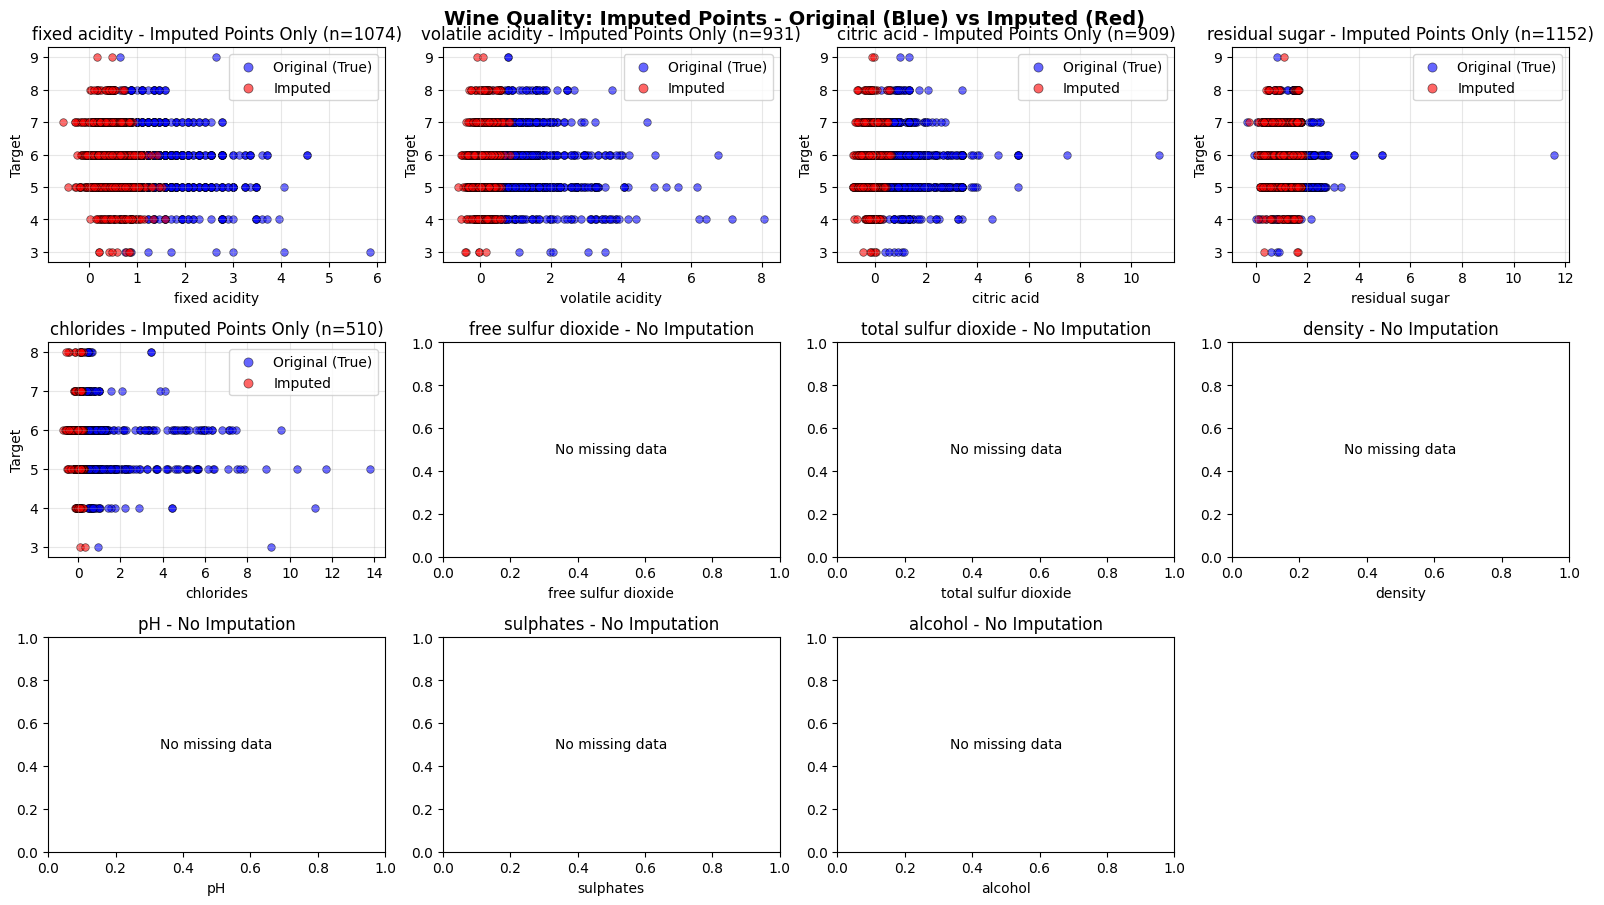

In [15]:
# Plot imputed points only
plot_imputed_points_only(X_train_std, X_train_notmiwae_imputed, y_train, mask_train,
                         feature_names=wine_data.columns[:-1],
                         dataset_name='Wine Quality')

In [16]:
# Train Ridge regression on all three versions
model_orig = Ridge(alpha=1.0).fit(X_train_std, y_train)
model_mean = Ridge(alpha=1.0).fit(X_train_mean_imputed, y_train)
model_notmiwae = Ridge(alpha=1.0).fit(X_train_notmiwae_imputed, y_train)

rmse_orig = np.sqrt(mean_squared_error(y_test, model_orig.predict(X_test_std)))
rmse_mean = np.sqrt(mean_squared_error(y_test, model_mean.predict(X_test_std)))
rmse_notmiwae = np.sqrt(mean_squared_error(y_test, model_notmiwae.predict(X_test_std)))

results['wine'] = {'original': rmse_orig, 'mean_imputed': rmse_mean, 'notmiwae_imputed': rmse_notmiwae, 'metric': 'RMSE'}

print("=" * 60)
print("Wine Quality - Imputation Method Comparison")
print("=" * 60)
print(f"Original Complete Data:     {rmse_orig:.4f}")
print(f"Mean Imputation:            {rmse_mean:.4f}")
print(f"Not-MIWAE Imputation:       {rmse_notmiwae:.4f}")
print("=" * 60)
print(f"Mean vs Original:           {rmse_mean - rmse_orig:+.4f}")
print(f"Not-MIWAE vs Original:      {rmse_notmiwae - rmse_orig:+.4f}")
print(f"Not-MIWAE vs Mean:          {rmse_notmiwae - rmse_mean:+.4f}")

Wine Quality - Imputation Method Comparison
Original Complete Data:     0.7544
Mean Imputation:            0.8148
Not-MIWAE Imputation:       0.7851
Mean vs Original:           +0.0604
Not-MIWAE vs Original:      +0.0307
Not-MIWAE vs Mean:          -0.0297


## 2. Breast Cancer Wisconsin (Classification)

In [17]:
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data.astype(np.float32), cancer.target

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print(f"Breast Cancer: {X_train.shape[0]} train, {X_test.shape[0]} test, {X_train.shape[1]} features")

Breast Cancer: 455 train, 114 test, 30 features


In [18]:
# Introduce missing values
_, X_train_filled, mask_train = introduce_mnar_missing(X_train_std)
print(f"Missing rate: {(1 - mask_train.mean()):.2%}")

# Mean imputation
X_train_mean_imputed = compute_mean_imputation(X_train_std, X_train_filled, mask_train)

# Not-MIWAE imputation
X_train_notmiwae_imputed = train_notmiwae_and_impute(X_train_filled, mask_train, n_epochs=100)

Missing rate: 12.23%
  Epoch 50/100, Loss: 27.8721
  Epoch 100/100, Loss: 22.5932


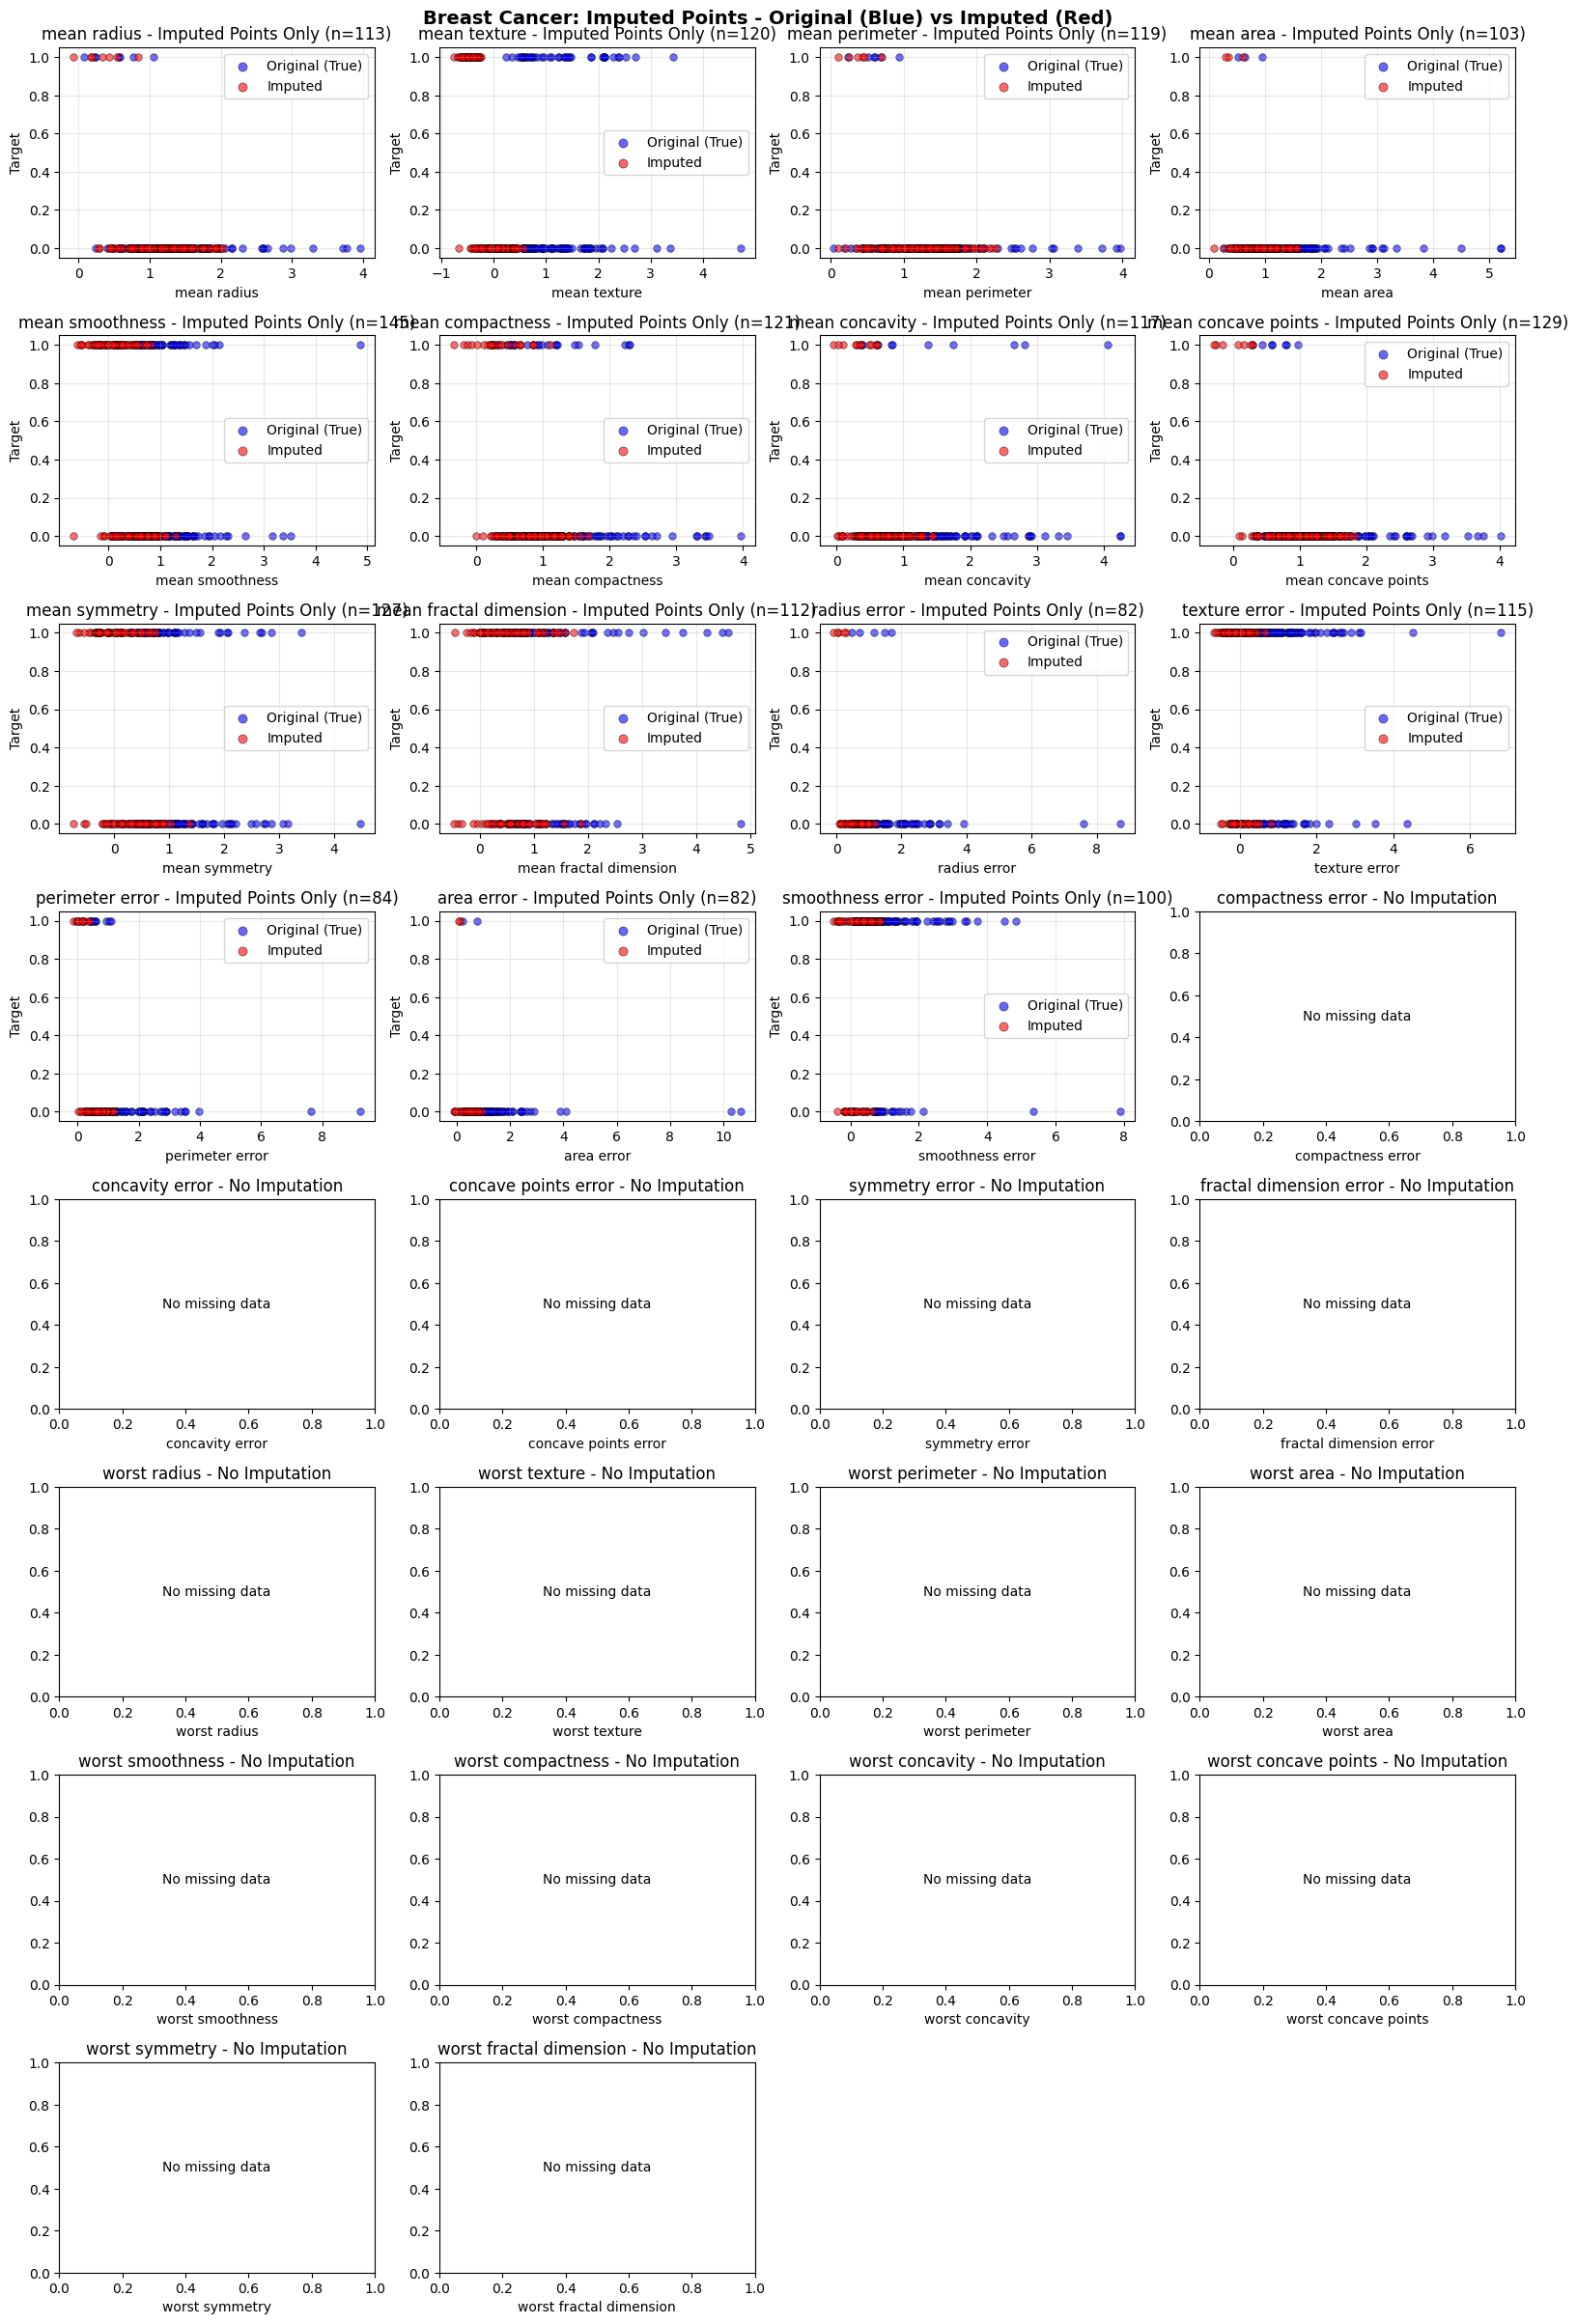

In [19]:
# Plot imputed points only
plot_imputed_points_only(X_train_std, X_train_notmiwae_imputed, y_train, mask_train,
                         feature_names=cancer.feature_names,
                         dataset_name='Breast Cancer')

In [20]:
# Train Logistic Regression on all three versions
model_orig = LogisticRegression(max_iter=200).fit(X_train_std, y_train)
model_mean = LogisticRegression(max_iter=200).fit(X_train_mean_imputed, y_train)
model_notmiwae = LogisticRegression(max_iter=200).fit(X_train_notmiwae_imputed, y_train)

acc_orig = accuracy_score(y_test, model_orig.predict(X_test_std))
acc_mean = accuracy_score(y_test, model_mean.predict(X_test_std))
acc_notmiwae = accuracy_score(y_test, model_notmiwae.predict(X_test_std))

results['breast_cancer'] = {'original': acc_orig, 'mean_imputed': acc_mean, 'notmiwae_imputed': acc_notmiwae, 'metric': 'Accuracy'}

print("=" * 60)
print("Breast Cancer - Imputation Method Comparison")
print("=" * 60)
print(f"Original Complete Data:     {acc_orig:.4f}")
print(f"Mean Imputation:            {acc_mean:.4f}")
print(f"Not-MIWAE Imputation:       {acc_notmiwae:.4f}")
print("=" * 60)
print(f"Mean vs Original:           {acc_mean - acc_orig:+.4f}")
print(f"Not-MIWAE vs Original:      {acc_notmiwae - acc_orig:+.4f}")
print(f"Not-MIWAE vs Mean:          {acc_notmiwae - acc_mean:+.4f}")

Breast Cancer - Imputation Method Comparison
Original Complete Data:     0.9737
Mean Imputation:            0.9737
Not-MIWAE Imputation:       0.9825
Mean vs Original:           +0.0000
Not-MIWAE vs Original:      +0.0088
Not-MIWAE vs Mean:          +0.0088


In [21]:
# Summary of all experiments
print("\n" + "=" * 80)
print("FINAL SUMMARY: Original vs Mean Imputation vs Not-MIWAE Imputation")
print("=" * 80 + "\n")

for dataset_name, result in results.items():
    print(f"{dataset_name.replace('_', ' ').title()}")
    print("-" * 60)
    metric = result['metric']
    if 'mean_imputed' in result:
        print(f"  Original:          {result['original']:.4f}")
        print(f"  Mean Imputation:   {result['mean_imputed']:.4f}")
        print(f"  Not-MIWAE:         {result['notmiwae_imputed']:.4f}")
        print(f"  Improvement (Mean): {(result['mean_imputed'] - result['original']) / result['original'] * 100:+.2f}%")
        print(f"  Improvement (Not-MIWAE): {(result['notmiwae_imputed'] - result['original']) / result['original'] * 100:+.2f}%")
    else:
        print(f"  Original:  {result['original']:.4f}")
        print(f"  Imputed:   {result['imputed']:.4f}")
    print()


FINAL SUMMARY: Original vs Mean Imputation vs Not-MIWAE Imputation

Wine
------------------------------------------------------------
  Original:          0.7544
  Mean Imputation:   0.8148
  Not-MIWAE:         0.7851
  Improvement (Mean): +8.01%
  Improvement (Not-MIWAE): +4.07%

Breast Cancer
------------------------------------------------------------
  Original:          0.9737
  Mean Imputation:   0.9737
  Not-MIWAE:         0.9825
  Improvement (Mean): +0.00%
  Improvement (Not-MIWAE): +0.90%

